# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.ensemble import RandomForestClassifier

import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import xgboost as xgb

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

import os

In [2]:
# loading previous cleaned dataset
import sqlite3
con = sqlite3.connect("final.sqlite")

In [3]:
data = pd.read_sql_query("select * from Reviews", con)

In [4]:
print(data.shape)
data.head()

(364171, 12)


index      Id   ProductId          UserId               ProfileName  \
0  138706  150524  0006641040   ACITT7DI6IDDL           shari zychinski   
1  138683  150501  0006641040   AJ46FKXOVC7NR        Nicholas A Mesiano   
2  417839  451856  B00004CXX9   AIUWLEQ1ADEG5          Elizabeth Medina   
3  346055  374359  B00004CI84  A344SMIA5JECGM           Vincent P. Ross   
4  417838  451855  B00004CXX9   AJH6LUC1UT1ON  The Phantom of the Opera   

   HelpfulnessNumerator  HelpfulnessDenominator     Score       Time  \
0                     0                       0  positive  939340800   
1                     2                       2  positive  940809600   
2                     0                       0  positive  944092800   
3                     1                       2  positive  944438400   
4                     0                       0  positive  946857600   

                                             Summary  \
0                          EVERY book is educational   
1  This whole series is great way to spend time w...   
2                               Entertainingl Funny!   
3                            A modern day fairy tale   
4                                         FANTASTIC!   

                                                Text  \
0  this witty little book makes my son laugh at l...   
1  I can remember seeing the show when it aired o...   
2  Beetlejuice is a well written movie ..... ever...   
3  A twist of rumplestiskin captured on film, sta...   
4  Beetlejuice is an excellent and funny movie. K...   

                                         CleanedText  
0  witti littl book make son laugh loud recit car...  
1  rememb see show air televis year ago child sis...  
2  beetlejuic well written movi everyth excel act...  
3  twist rumplestiskin captur film star michael k...  
4  beetlejuic excel funni movi keaton hilari wack...

In [5]:
final = data
# Sort data based on time
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final = final.sort_values(by = "Time")
final['Score'] = (final.Score.str.match('positive')).astype(int)
final.head()


index      Id   ProductId          UserId               ProfileName  \
0  138706  150524  0006641040   ACITT7DI6IDDL           shari zychinski   
1  138683  150501  0006641040   AJ46FKXOVC7NR        Nicholas A Mesiano   
2  417839  451856  B00004CXX9   AIUWLEQ1ADEG5          Elizabeth Medina   
3  346055  374359  B00004CI84  A344SMIA5JECGM           Vincent P. Ross   
4  417838  451855  B00004CXX9   AJH6LUC1UT1ON  The Phantom of the Opera   

   HelpfulnessNumerator  HelpfulnessDenominator  Score       Time  \
0                     0                       0      1 1999-10-08   
1                     2                       2      1 1999-10-25   
2                     0                       0      1 1999-12-02   
3                     1                       2      1 1999-12-06   
4                     0                       0      1 2000-01-03   

                                             Summary  \
0                          EVERY book is educational   
1  This whole series is great way to spend time w...   
2                               Entertainingl Funny!   
3                            A modern day fairy tale   
4                                         FANTASTIC!   

                                                Text  \
0  this witty little book makes my son laugh at l...   
1  I can remember seeing the show when it aired o...   
2  Beetlejuice is a well written movie ..... ever...   
3  A twist of rumplestiskin captured on film, sta...   
4  Beetlejuice is an excellent and funny movie. K...   

                                         CleanedText  
0  witti littl book make son laugh loud recit car...  
1  rememb see show air televis year ago child sis...  
2  beetlejuic well written movi everyth excel act...  
3  twist rumplestiskin captur film star michael k...  
4  beetlejuic excel funni movi keaton hilari wack...

In [6]:
kmeans = final.CleanedText[0:50000]

aglo = final.CleanedText[0:1000]

dbscan = final.CleanedText[0:5000]
print("kmeans data shape ",kmeans.shape )
print("aglommerative data shape ",aglo.shape )
print("dbscan data shape ",dbscan.shape )

kmeans data shape  (50000,)
aglommerative data shape  (1000,)
dbscan data shape  (5000,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [7]:
# since my ram is only 4gb so i am performing Bag Of Words operation on 100k data only
#BOW
count_vect = CountVectorizer( min_df=10) #in scikit-learn
bowKm = count_vect.fit_transform(kmeans.values)
print("the shape of out Kmeans BOW vectorizer ",bowKm.get_shape())


the shape of out Kmeans BOW vectorizer  (50000, 6132)


## [4.3] TF-IDF

In [8]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df = 10)
tfKm = tf_idf_vect.fit_transform(kmeans.values)
print("the shape of out Kmeans tfidf vectorizer ",tfKm.get_shape())


tf_idf_vect1 = TfidfVectorizer(ngram_range=(1,2),min_df = 10)
tfAglo = tf_idf_vect1.fit_transform(aglo.values)
print("the shape of out Aglo tfidf vectorizer ",tfAglo.get_shape())

tf_idf_vect2 = TfidfVectorizer(ngram_range=(1,2),min_df = 10)
tfDb = tf_idf_vect2.fit_transform(dbscan.values)
print("the shape of out dbscan tfidf vectorizer ",tfDb.get_shape())


the shape of out Kmeans tfidf vectorizer  (50000, 28390)
the shape of out Aglo tfidf vectorizer  (1000, 995)
the shape of out dbscan tfidf vectorizer  (5000, 3535)


In [9]:
# removing html tags and apostrophes if present.
import re
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [10]:
# converting the kmeans set into clean form which does not contain html tags etc.
import gensim
i=0
list_of_sent_train=[]
for sent in kmeans.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

In [11]:
# Doing the same for aglo dataset.
list_of_sent_test=[]
for sent in aglo.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [12]:
# Doing the same for aglo dataset.
list_of_sent_test1=[]
for sent in dbscan.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test1.append(filtered_sentence)

In [13]:
# Training the wor2vec model using kmeans dataset
w2v_model=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=200, workers=4) 

In [14]:
# Training the wor2vec model using aglomerative dataset
w2v_model1=gensim.models.Word2Vec(list_of_sent_test,min_count=5,size=200, workers=4) 

In [15]:
# Training the wor2vec model using aglomerative dataset
w2v_model2=gensim.models.Word2Vec(list_of_sent_test1,min_count=5,size=200, workers=4) 

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [16]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this train
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
    
print (len(sent_vectors_train))
print (len(sent_vectors_train[0]))

50000
200


In [17]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this test
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model1.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
    
print (len(sent_vectors_test))
print (len(sent_vectors_test[0]))

1000
200


In [18]:
sent_vectors_test1 = []; # the avg-w2v for each sentence/review is stored in this test
for sent in list_of_sent_test1: # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model2.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test1.append(sent_vec)
    
print (len(sent_vectors_test1))
print (len(sent_vectors_test1[0]))

5000
200


#### [4.4.1.2] TFIDF weighted W2v

In [19]:
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names

In [20]:
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length
    weight_sum = 0.0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
    
print (len(tfidf_sent_vectors_train))
print (len(tfidf_sent_vectors_train[0]))

50000
200


In [21]:
tfidf_feat = tf_idf_vect1.get_feature_names() # tfidf words/col-names

In [22]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
    
print (len(tfidf_sent_vectors_test))
print (len(tfidf_sent_vectors_test[0]))

1000
200


In [23]:
tfidf_feat = tf_idf_vect2.get_feature_names() # tfidf words/col-names

In [24]:
tfidf_sent_vectors_test1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test1: # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test1.append(sent_vec)
    row += 1
    
print (len(tfidf_sent_vectors_test1))
print (len(tfidf_sent_vectors_test1[0]))

5000
200


In [25]:
from sklearn.cluster import KMeans
def kmeans1(data):
    k = [2,3,4,5,6,7,8,9]
    inertia = []
    for i in k:
        kmeans1 = KMeans(n_clusters=i, init='k-means++')
        kmeans1.fit(data)
        inertia.append(kmeans.inertia_)
        
    return inertia , k

In [26]:
def inertiaPlot(inertia, k):
    plt.plot(k, inertia)
    plt.xlabel("k")
    plt.ylabel("inertia")
    plt.title("elbow knee method")
    plt.show()

In [62]:
#initialing the table
from prettytable import PrettyTable
kTable = PrettyTable()
kTable.field_names = ["Vectorizer", "Type", "clusters", "ineria"]
print(kTable)

+------------+------+----------+--------+
| Vectorizer | Type | clusters | ineria |
+------------+------+----------+--------+
+------------+------+----------+--------+


In [63]:
#initialing the table
from prettytable import PrettyTable
dbTable = PrettyTable()
dbTable.field_names = ["Vectorizer", "Type", "eps"]
print(dbTable)

+------------+------+-----+
| Vectorizer | Type | eps |
+------------+------+-----+
+------------+------+-----+


In [28]:
from wordcloud import WordCloud, STOPWORDS
def word_cloud_per_cluster(train, model, trainData):
    pred_labels = model.labels_
    words_clusterwise = []
    count = 0
    for label in np.unique(model.labels_):
        for i in range(train.shape[0]):
            if label == pred_labels[i] and count < 50:
                count += 1
                words_clusterwise = [trainData[i].split() ]
            if count == 50:
                    break
        wordcloud = WordCloud(width = 800, height = 800,
                    max_words = 100,
                    background_color = 'black',
                    stopwords = None,
                    min_font_size = 10).generate(str(words_clusterwise))
        words_clusterwise = []
        count = 0
        print(words_clusterwise)
        plt.figure(figsize = (5,5), facecolor = None)
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.tight_layout(pad = 0)
        plt.title("Cluster " + str(label))

        plt.show()

In [33]:
from wordcloud import WordCloud, STOPWORDS
def word_cloud_per_cluster1(train, model, trainData):
    pred_labels = model.labels_
    words_clusterwise = []
    count = 0
    for label in np.unique(model.labels_):
        for i in range(len(sent_vectors_test)):
            if label == pred_labels[i] and count < 50:
                count += 1
                words_clusterwise = [trainData[i].split() ]
            if count == 50:
                    break
        wordcloud = WordCloud(width = 800, height = 800,
                    max_words = 100,
                    background_color = 'black',
                    stopwords = None,
                    min_font_size = 10).generate(str(words_clusterwise))
        words_clusterwise = []
        count = 0
        print(words_clusterwise)
        plt.figure(figsize = (5,5), facecolor = None)
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.tight_layout(pad = 0)
        plt.title("Cluster " + str(label))

        plt.show()

In [29]:
# from wordcloud import WordCloud, STOPWORDS
# def word_cloud_per_cluster(train, model, trainData, label):
#     pred_labels = model.predict(train)
#     words_clusterwise = []
# #     for label in np.unique(model.labels_):
#     words_clusterwise = [trainData[i].split() for i in range(train.shape[0]) if label == pred_labels[i]]
#     wordcloud = WordCloud(width = 800, height = 800,
#                 max_words = 100,
#                 background_color = 'black',
#                 stopwords = None,
#                 min_font_size = 10).generate(str(words_clusterwise))
        
#     plt.figure(figsize = (5,5), facecolor = None)
#     plt.imshow(wordcloud)
#     plt.axis('off')
#     plt.tight_layout(pad = 0)
#     plt.title("Cluster " + str(label))
        
#     plt.show()

# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [31]:
# Please write all the code with proper documentation
i, k = kmeans1(bowKm)

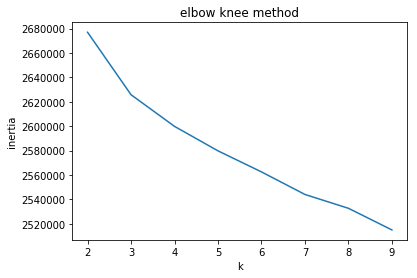

In [32]:
inertiaPlot(i, k)

In [33]:
print(i)

[2676997.717875744, 2625800.0370650413, 2599850.070017097, 2579789.3897536467, 2562537.8632631307, 2544039.9735233807, 2532698.23523728, 2514979.2809397783]


###### Observation
For cluster 9 we got the minimum inertia

In [75]:
model1 = KMeans(n_clusters=9, init='k-means++')
model1.fit(bowKm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [64]:
kTable.add_row(["BOW", "Kmeans", 9,2514979.2809397783 ])

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

[]


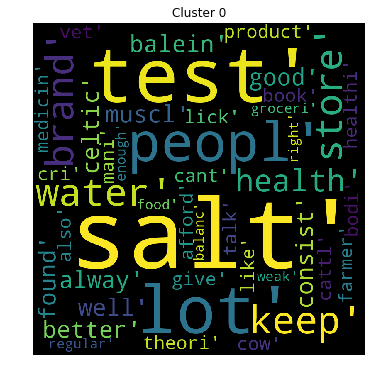

[]


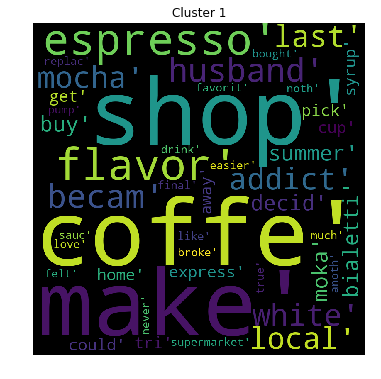

[]


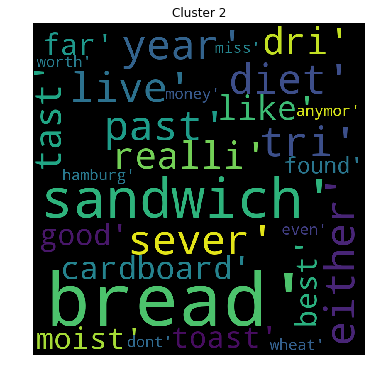

[]


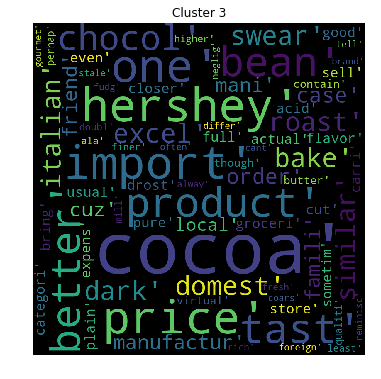

[]


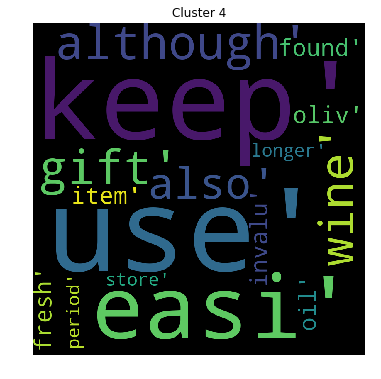

[]


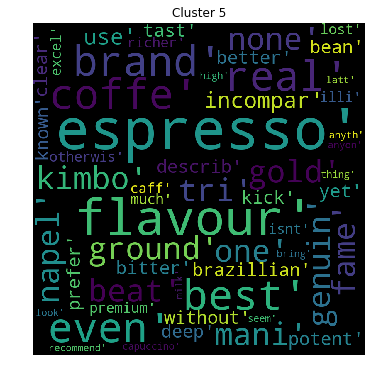

[]


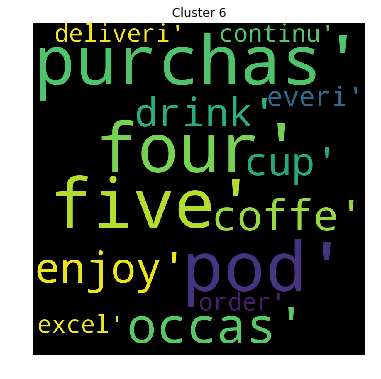

[]


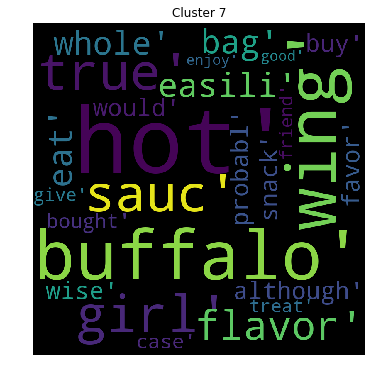

[]


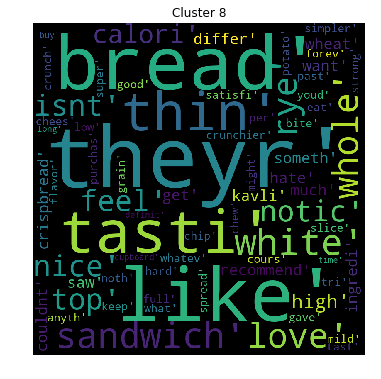

In [76]:
word_cloud_per_cluster(bowKm, model1, kmeans)

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [55]:
k = [2,3,4,5,6,7,8,9]
inertia = []
for i in k:
    kmeans1 = KMeans(n_clusters=i, init='k-means++')
    kmeans1.fit(tfKm)
    inertia.append(kmeans1.inertia_)
        
i2 = inertia

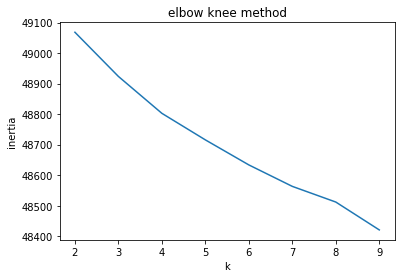

In [56]:
inertiaPlot(i2, k)

In [64]:
model2 = KMeans(n_clusters=9, init='k-means++')
model2.fit(tfKm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [65]:
kTable.add_row(["TF-Idf", "Kmeans", 9,48461.44546 ])

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

[]


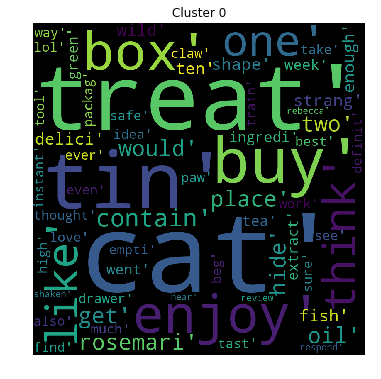

[]


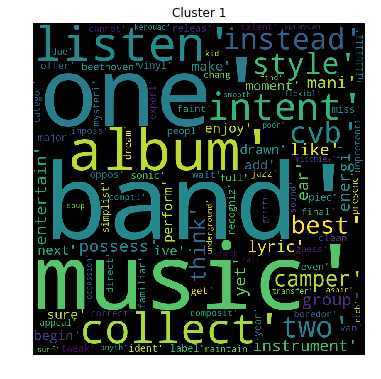

[]


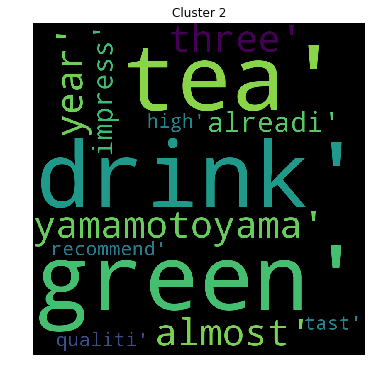

[]


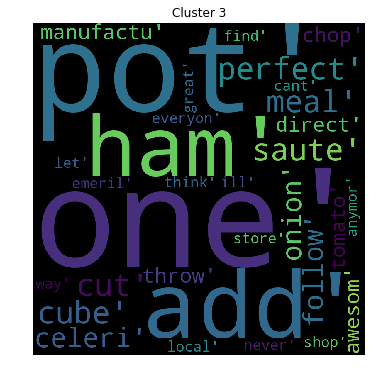

[]


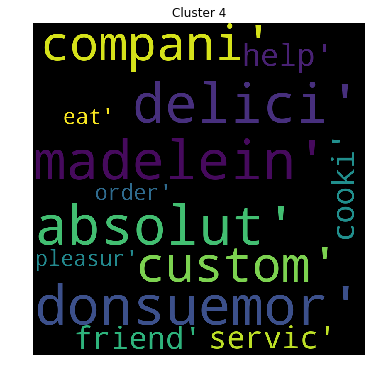

[]


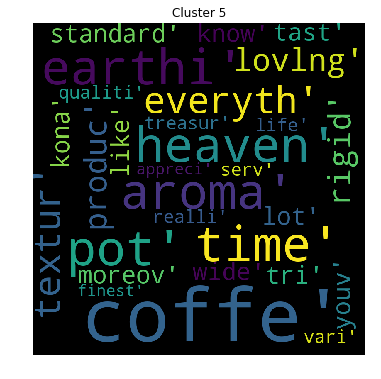

[]


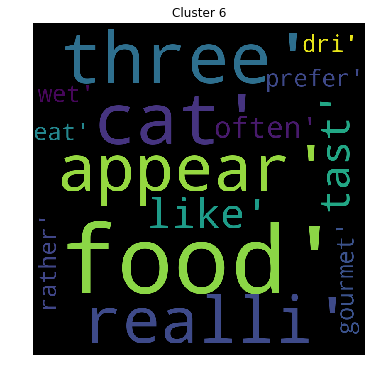

[]


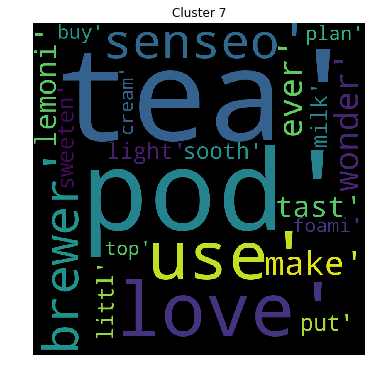

[]


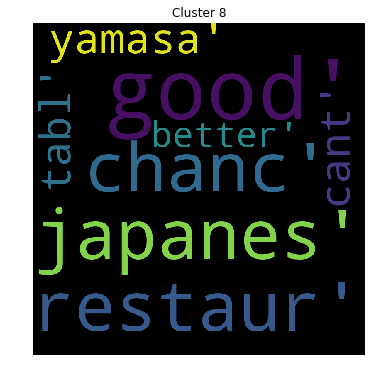

In [74]:
word_cloud_per_cluster(tfKm, model2, kmeans)

### [5.1.5] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 3</font>

In [101]:
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)
tfidf_sent_vectors_train = np.nan_to_num(tfidf_sent_vectors_train)

In [60]:
# Please write all the code with proper documentation
i3, k2 = kmeans(tfidf_sent_vectors_train)

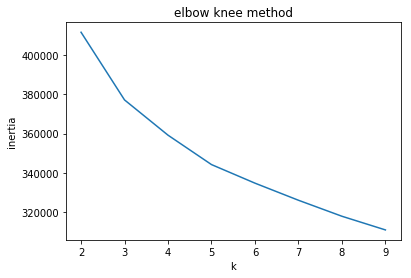

In [61]:
inertiaPlot(i3, k2)

In [68]:
print(i3)

[411518.2084448283, 377116.3948439224, 359193.3362538167, 344245.3591586147, 334802.23585275543, 326112.13098413777, 317977.7797708694, 311031.27361758315]


In [102]:
# Please write all the code with proper documentation
model3 = KMeans(n_clusters=9, init='k-means++')
model3.fit(tfidf_sent_vectors_train)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [66]:
kTable.add_row(["Tf-Idf W2v", "Kmeans", 9,311031.27361758315 ])

### [5.1.7] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 4</font>

In [63]:
# Please write all the code with proper documentation
i3, k3 = kmeans(sent_vectors_train)

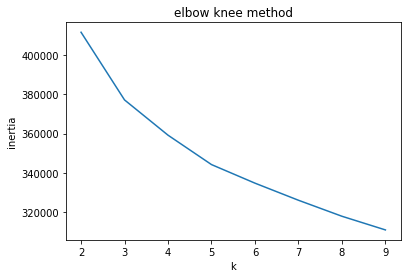

In [64]:
inertiaPlot(i3, k3)

In [67]:
print(i3)

[411518.23138368287, 377116.3952592949, 359193.34021283116, 344245.35126052005, 334802.32500982203, 326112.583766121, 317977.8135160879, 311031.19765353185]


In [67]:
kTable.add_row(["Avg W2v", "Kmeans", 9, 311031.19765353185])

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [30]:
# Please write all the code with proper documentation
from sklearn.cluster import AgglomerativeClustering
agg1 = AgglomerativeClustering(n_clusters=2)
agg1.fit(sent_vectors_test)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x7f2d58010b70>)

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

[]


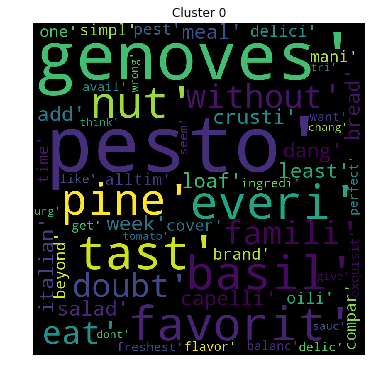

[]


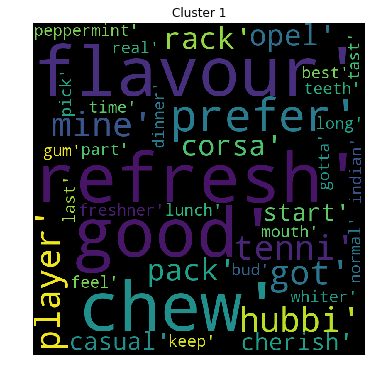

In [36]:
word_cloud_per_cluster1(sent_vectors_test, agg1, aglo)

In [37]:
# Please write all the code with proper documentation
agg2 = AgglomerativeClustering(n_clusters=5)
agg2.fit(sent_vectors_test)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func=<function mean at 0x7f2d58010b70>)

[]


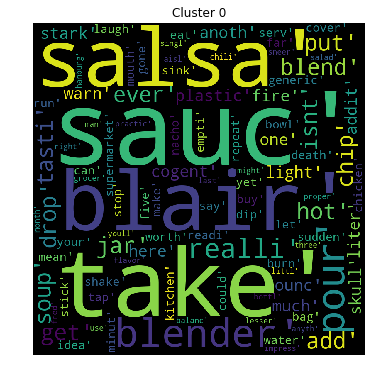

[]


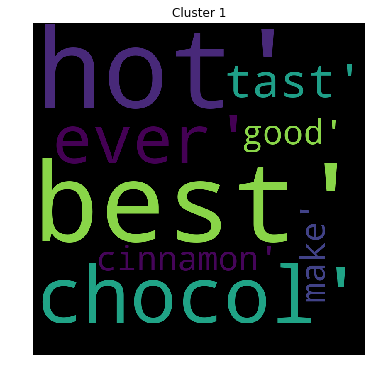

[]


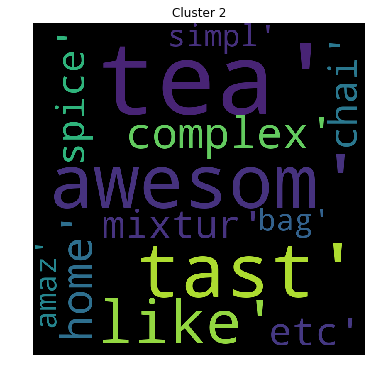

[]


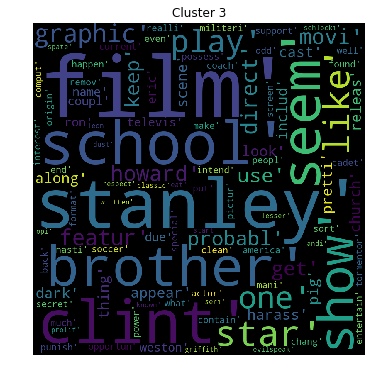

[]


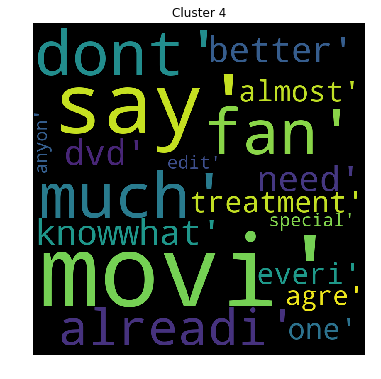

In [38]:
word_cloud_per_cluster1(sent_vectors_test, agg2, aglo)

In [39]:
# Please write all the code with proper documentation
agg3 = AgglomerativeClustering(n_clusters=7)
agg3.fit(sent_vectors_test)


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=7,
            pooling_func=<function mean at 0x7f2d58010b70>)

[]


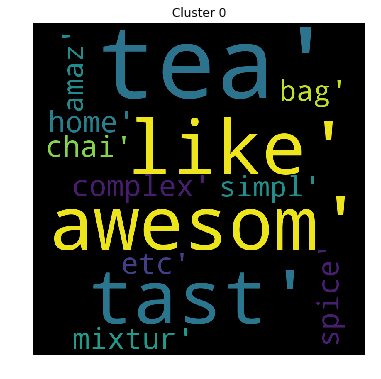

[]


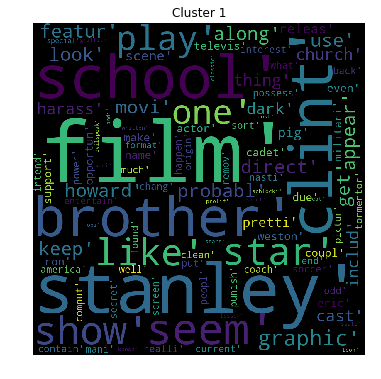

[]


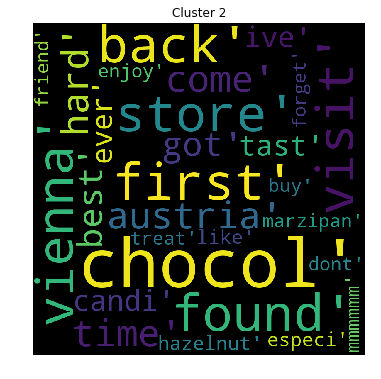

[]


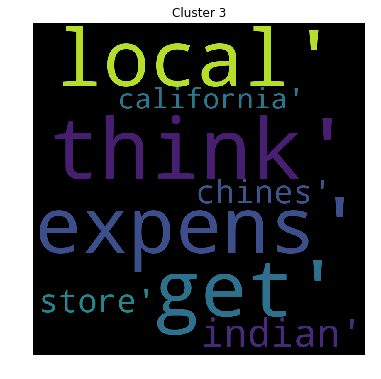

[]


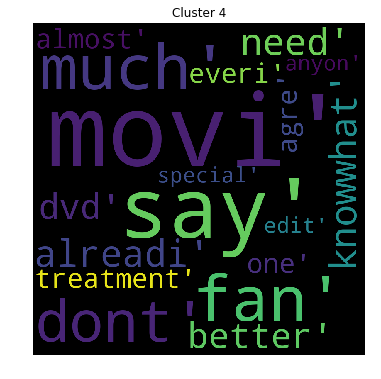

[]


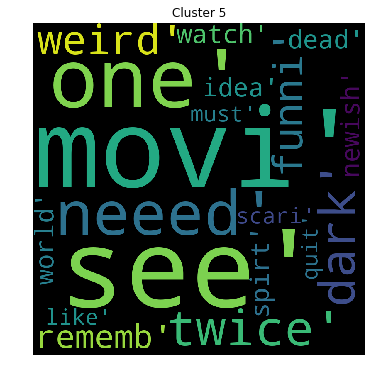

[]


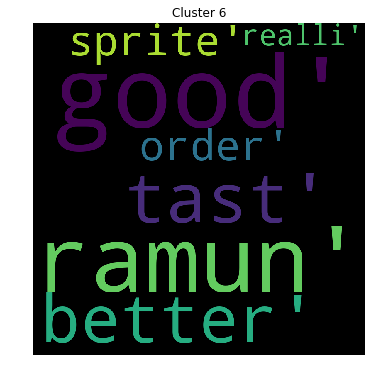

In [40]:
word_cloud_per_cluster1(sent_vectors_test, agg3, aglo)

In [83]:
# Please write all the code with proper documentation

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [41]:
# nan values are assigned 0 (if present)
sent_vectors_train = np.array(sent_vectors_train)
sent_vectors_train = np.nan_to_num(sent_vectors_train)
sent_vectors_test = np.array(sent_vectors_test)
sent_vectors_test = np.nan_to_num(sent_vectors_test)

sent_vectors_test1 = np.array(sent_vectors_test1)
sent_vectors_test1 = np.nan_to_num(sent_vectors_test1)

In [42]:
# nan values are assigned 0 (if present)
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)
tfidf_sent_vectors_train = np.nan_to_num(tfidf_sent_vectors_train)
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)
tfidf_sent_vectors_test = np.nan_to_num(tfidf_sent_vectors_test)

tfidf_sent_vectors_test1 = np.array(tfidf_sent_vectors_test1)
tfidf_sent_vectors_test1 = np.nan_to_num(tfidf_sent_vectors_test1)

In [43]:
# Please write all the code with proper documentation
tfagg1 = AgglomerativeClustering(n_clusters=2)
tfagg1.fit(tfidf_sent_vectors_test)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func=<function mean at 0x7f2d58010b70>)

In [93]:
# Please write all the code with proper documentation
tfagg2 = AgglomerativeClustering(n_clusters=5)
tfagg2.fit(tfidf_sent_vectors_test)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func=<function mean at 0x7face40d9b70>)

In [94]:
# Please write all the code with proper documentation
tfagg3 = AgglomerativeClustering(n_clusters=7)
tfagg3.fit(tfidf_sent_vectors_test)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=7,
            pooling_func=<function mean at 0x7face40d9b70>)

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [3]:
# Please write all the code with proper documentation

In [48]:
# Computing 400th Nearest neighbour distance code.
minPts = 2 * 200
# Lower bound function copied from -> https://gist.github.com/m00nlight/0f9306b4d4e61ba0195f
def lower_bound(nums, target): # This function return the number in the array just greater than or equal to itself.
    l, r = 0, len(nums) - 1
    while l <= r: # Binary searching.
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l
# compute400thnearestneighbour function copied from https://raw.githubusercontent.com/Prakhar-FF13/Amazon-Fine-Food-Reviews/master/Decision%2BTrees%2BAmazon%2BFood%2BReviews.ipynb
def compute400thnearestneighbour(x, data): # Returns the distance of 400th nearest neighbour.
    dists = []
    for val in data:
        dist = np.sum((x - val) **2 ) # computing distances.
        if(len(dists) == 400 and dists[399] > dist): # If distance is larger than current largest distance found.
            l = int(lower_bound(dists, dist)) # Using the lower bound function to get the right position.
            if l < 400 and l >= 0 and dists[l] > dist:
                dists[l] = dist
        else:
            dists.append(dist)
            dists.sort()
    
    return dists[399] # Dist 199 contains the distance of 200th nearest neighbour.

In [49]:
# Computing the 200th nearest neighbour distance of some point the dataset:
fourhundrethneigh = []
for val in sent_vectors_test1[:1500]:
    fourhundrethneigh.append( compute400thnearestneighbour(val, sent_vectors_test1[:1500]) )
fourhundrethneigh.sort()

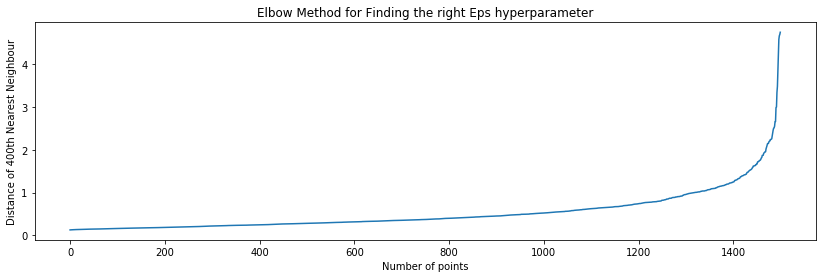

In [50]:
# Plotting for the Elbow Method :
plt.figure(figsize=(14,4))
plt.title("Elbow Method for Finding the right Eps hyperparameter")
plt.plot([x for x in range(len(fourhundrethneigh))], fourhundrethneigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of 400th Nearest Neighbour")
plt.show()

In [51]:
from sklearn.cluster import DBSCAN
scan1 = DBSCAN(eps=2, min_samples=400)
scan1.fit(sent_vectors_test1)

DBSCAN(algorithm='auto', eps=2, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=400, n_jobs=1, p=None)

In [58]:
scan1.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [68]:
dbTable.add_row(["Avg W2v","Dbscan", "2"])

### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

[]


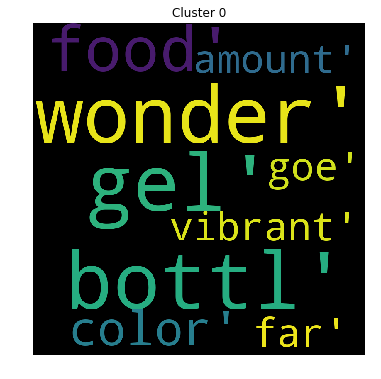

In [54]:
word_cloud_per_cluster1(sent_vectors_test1, scan1, dbscan)

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [56]:
# Please write all the code with proper documentation
# Computing the 200th nearest neighbour distance of some point the dataset:
fourhundrethneigh = []
for val in tfidf_sent_vectors_test1[:1500]:
    fourhundrethneigh.append( compute400thnearestneighbour(val, tfidf_sent_vectors_test1[:1500]) )
fourhundrethneigh.sort()


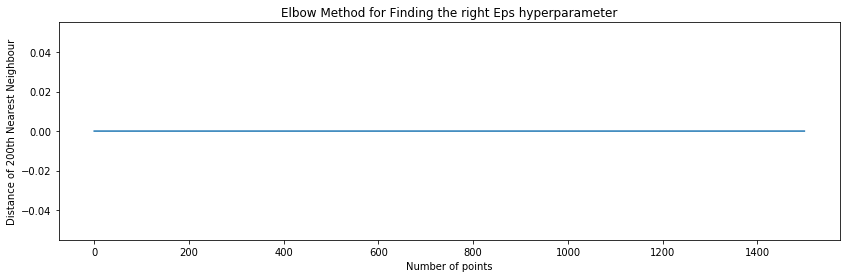

In [57]:
# Plotting for the Elbow Method :
plt.figure(figsize=(14,4))
plt.title("Elbow Method for Finding the right Eps hyperparameter")
plt.plot([x for x in range(len(fourhundrethneigh))], fourhundrethneigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.show()

In [60]:

scan2 = DBSCAN(eps=1, min_samples=400)
scan2.fit(tfidf_sent_vectors_test1)

DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=400, n_jobs=1, p=None)

In [69]:
dbTable.add_row(["Tfidf W2v","Dbscan", "1"])

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

[]


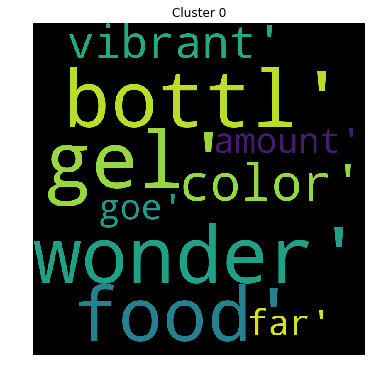

In [61]:
# Please write all the code with proper documentation
word_cloud_per_cluster1(tfidf_sent_vectors_test1, scan2, dbscan)

# [6] Conclusions

In [71]:
# Please compare all your models using Prettytable library. 
# You can have 3 tables, one each for kmeans, agllomerative and dbscan
print("kmeans")
print(kTable)

kmeans
+------------+--------+----------+--------------------+
| Vectorizer |  Type  | clusters |       ineria       |
+------------+--------+----------+--------------------+
|    BOW     | Kmeans |    9     | 2514979.2809397783 |
|   TF-Idf   | Kmeans |    9     |    48461.44546     |
| Tf-Idf W2v | Kmeans |    9     | 311031.27361758315 |
|  Avg W2v   | Kmeans |    9     | 311031.19765353185 |
+------------+--------+----------+--------------------+


In [72]:
print("DBscan")
print(dbTable)

DBscan
+------------+--------+-----+
| Vectorizer |  Type  | eps |
+------------+--------+-----+
|  Avg W2v   | Dbscan |  2  |
| Tfidf W2v  | Dbscan |  1  |
+------------+--------+-----+
